# TensorFlow Tutorial #16
# Reinforcement Learning (Q-Learning)

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

This tutorial is about so-called Reinforcement Learning in which an agent is learning how to navigate some environment, in this case Atari games from the 1970-80's. The agent does not know anything about the game and must learn how to play it from trial and error. The only information that is available to the agent is the screen output of the game, and whether the previous action resulted in a reward or penalty.

This is a very difficult problem in Machine Learning / Artificial Intelligence, because the agent must both learn to distinguish features in the game-images, and then connect the occurence of certain features in the game-images with its own actions and a reward or penalty that may be deferred many steps into the future.

This problem was first solved by the researchers from Google DeepMind. This tutorial is based on the main ideas from their early research papers (especially [this](https://arxiv.org/abs/1312.5602) and [this](http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html)), although we make several changes because the original DeepMind algorithm was awkward and over-complicated in some ways. But it turns out that you still need several tricks in order to stabilize the training of the agent, so the implementation in this tutorial is unfortunately also somewhat complicated.

The basic idea is to have the agent estimate so-called Q-values whenever it sees an image from the game-environment. The Q-values tell the agent which action is most likely to lead to the highest cumulative reward in the future. The problem is then reduced to finding these Q-values and storing them for later retrieval using a function approximator.

This builds on some of the previous tutorials. You should be familiar with TensorFlow and Convolutional Neural Networks from Tutorial #01 and #02. It will also be helpful if you are familiar with one of the builder APIs in Tutorials #03 or #03-B.

## The Problem

This tutorial uses the Atari game Breakout, where the player or agent is supposed to hit a ball with a paddle, thus avoiding death while scoring points when the ball smashes pieces of a wall.

When a human learns to play a game like this, the first thing to figure out is what part of the game environment you are controlling - in this case the paddle at the bottom. If you move right on the joystick then the paddle moves right and vice versa. The next thing is to figure out what the goal of the game is - in this case to smash as many bricks in the wall as possible so as to maximize the score. Finally you need to learn what to avoid - in this case you must avoid dying by letting the ball pass beside the paddle.

Below are shown 3 images from the game that demonstrate what we need our agent to learn. In the image to the left, the ball is going downwards and the agent must learn to move the paddle so as to hit the ball and avoid death. The image in the middle shows the paddle hitting the ball, which eventually leads to the image on the right where the ball smashes some bricks and scores points. The ball then continues downwards and the process repeats.

![Illustration of the problem](images/16_problem.png)

The problem is that there are 10 states between the ball going downwards and the paddle hitting the ball, and there are an additional 18 states before the reward is obtained when the ball hits the wall and smashes some bricks. How can we teach an agent to connect these three situations and generalize to similar situations? The answer is to use so-called Reinforcement Learning with a Neural Network, as shown in this tutorial.

## Q-Learning

One of the simplest ways of doing Reinforcement Learning is called Q-learning. Here we want to estimate so-called Q-values which are also called action-values, because they map a state of the game-environment to a numerical value for each possible action that the agent may take. The Q-values indicate which action is expected to result in the highest future reward, thus telling the agent which action to take.

Unfortunately we do not know what the Q-values are supposed to be, so we have to estimate them somehow. The Q-values are all initialized to zero and then updated repeatedly as new information is collected from the agent playing the game. When the agent scores a point then the Q-value must be updated with the new information.

There are different formulas for updating Q-values, but the simplest is to set the new Q-value to the reward that was observed, plus the maximum Q-value for the following state of the game. This gives the total reward that the agent can expect from the current game-state and onwards. Typically we also multiply the max Q-value for the following state by a so-called discount-factor slightly below 1. This causes more distant rewards to contribute less to the Q-value, thus making the agent favour rewards that are closer in time.

The formula for updating the Q-value is:

    Q-value for state and action = reward + discount * max Q-value for next state

In academic papers, this is typically written with mathematical symbols like this:

$$
    Q(s_{t},a_{t}) \leftarrow \underbrace{r_{t}}_{\rm reward} + \underbrace{\gamma}_{\rm discount} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\rm estimate~of~future~rewards}
$$

Furthermore, when the agent loses a life, then we know that the future reward is zero because the agent is dead, so we set the Q-value for that state to zero.

### Simple Example

The images below demonstrate how Q-values are updated in a backwards sweep through the game-states that have previously been visited. In this simple example we assume all Q-values have been initialized to zero. The agent gets a reward of 1 point in the right-most image. This reward is then propagated backwards to the previous game-states, so when we see similar game-states in the future, we know that the given actions resulted in that reward.

The discounting is an exponentially decreasing function. This example uses a discount-factor of 0.97 so the Q-value for the 3rd image is about $0.885 \simeq 0.97^4$ because it is 4 states prior to the state that actually received the reward. Similarly for the other states. This example only shows one Q-value per state, but in reality there is one Q-value for each possible action in the state, and the Q-values are updated in a backwards-sweep using the formula above. This is shown in the next section.

![Q-values Simple Example](images/16_q-values-simple.png)

### Detailed Example

This is a more detailed example showing the Q-values for two successive states of the game-environment and how to update them.

![Q-values Detailed Example](images/16_q-values-details.png)

The Q-values for the possible actions have been estimated by a Neural Network. For the action NOOP in state $t$ the Q-value is estimated to be 2.900, which is the highest Q-value for that state so the agent takes that action, i.e. the agent does not do anything between state $t$ and $t+1$ because NOOP means "No Operation".

In state $t+1$ the agent scores 4 points, but this is limited to 1 point in this implementation so as to stabilize the training. The maximum Q-value for state $t+1$ is 1.830 for the action RIGHTFIRE. So if we select that action and continue to select the actions proposed by the Q-values estimated by the Neural Network, then the discounted sum of all the future rewards is expected to be 1.830.

Now that we know the reward of taking the NOOP action from state $t$ to $t+1$, we can update the Q-value to incorporate this new information. This uses the formula above:

$$
    Q(state_{t},NOOP) \leftarrow \underbrace{r_{t}}_{\rm reward} + \underbrace{\gamma}_{\rm discount} \cdot \underbrace{\max_{a}Q(state_{t+1}, a)}_{\rm estimate~of~future~rewards} = 1.0 + 0.97 \cdot 1.830 \simeq 2.775
$$

The new Q-value is 2.775 which is slightly lower than the previous estimate of 2.900. This Neural Network has already been trained for 150 hours so it is quite good at estimating Q-values, but earlier during the training, the estimated Q-values would be more different.

The idea is to have the agent play many, many games and repeatedly update the estimates of the Q-values as more information about rewards and penalties becomes available. This will eventually lead to good estimates of the Q-values, provided the training is numerically stable, as discussed further below. By doing this, we create a connection between rewards and prior actions.

## Motion Trace

If we only use a single image from the game-environment then we cannot tell which direction the ball is moving. The typical solution is to use multiple consecutive images to represent the state of the game-environment.

This implementation uses another approach by processing the images from the game-environment in a motion-tracer that outputs two images as shown below. The left image is from the game-environment and the right image is the processed image, which shows traces of recent movements in the game-environment. In this case we can see that the ball is going downwards and has bounced off the right wall, and that the paddle has moved from the left to the right side of the screen.

Note that the motion-tracer has only been tested for Breakout and partially tested for Space Invaders, so it may not work for games with more complicated graphics such as Doom.

![Motion Trace](images/16_motion-trace.png)

## Training Stability

We need a function approximator that can take a state of the game-environment as input and produce as output an estimate of the Q-values for that state. We will use a Convolutional Neural Network for this. Although they have achieved great fame in recent years, they are actually a quite old technologies with many problems - one of which is training stability. A significant part of the research for this tutorial was spent on tuning and stabilizing the training of the Neural Network.

To understand why training stability is a problem, consider the 3 images below which show the game-environment in 3 consecutive states. At state $t$ the agent is about to score a point, which happens in the following state $t+1$. Assuming all Q-values were zero prior to this, we should now set the Q-value for state $t+1$ to be 1.0 and it should be 0.97 for state $t$ if the discount-value is 0.97, according to the formula above for updating Q-values.

![Training Stability](images/16_training_stability.png)

If we were to train a Neural Network to estimate the Q-values for the two states $t$ and $t+1$ with Q-values 0.97 and 1.0, respectively, then the Neural Network will most likely be unable to distinguish properly between the images of these two states. As a result the Neural Network will also estimate a Q-value near 1.0 for state $t+2$ because the images are so similar. But this is clearly wrong because the Q-values for state $t+2$ should be zero as we do not know anything about future rewards at this point, and that is what the Q-values are supposed to estimate.

If this is continued and the Neural Network is trained after every new game-state is observed, then it will quickly cause the estimated Q-values to explode. This is an artifact of training Neural Networks which must have sufficiently large and diverse training-sets. For this reason we will use a so-called Replay Memory so we can gather a large number of game-states and shuffle them during training of the Neural Network.

## Flowchart

This flowchart shows roughly how Reinforcement Learning is implemented in this tutorial.  There are two main loops which are run sequentially until the Neural Network is sufficiently accurate at estimating Q-values.

The first loop is for playing the game and recording data. This uses the Neural Network to estimate Q-values from a game-state. It then stores the game-state along with the corresponding Q-values and reward/penalty in the Replay Memory for later use.

The other loop is activated when the Replay Memory is sufficiently full. First it makes a full backwards sweep through the Replay Memory to update the Q-values with the new rewards and penalties that have been observed. Then it performs an optimization run so as to train the Neural Network to better estimate these updated Q-values.

There are many more details in the implementation, such as decreasing the learning-rate and increasing the fraction of the Replay Memory being used during training, but this flowchart shows the main ideas.

![Flowchart](images/16_flowchart.png)

## Neural Network Architecture

The Neural Network used in this implementation has 3 convolutional layers, all of which have filter-size 3x3. The layers have 16, 32, and 64 output channels, respectively. The stride is 2 in the first two convolutional layers and 1 in the last layer.

Following the 3 convolutional layers there are 4 fully-connected layers each with 1024 units and ReLU-activation. Then there is a single fully-connected layer with linear activation used as the output of the Neural Network.

This architecture is different from those typically used in research papers from DeepMind and others. They often have large convolutional filter-sizes of 8x8 and 4x4 with high stride-values. This causes more aggressive down-sampling of the game-state images. They also typically have only a single fully-connected layer with 256 or 512 ReLU units.

During the research for this tutorial, it was found that smaller filter-sizes and strides in the convolutional layers, combined with several fully-connected layers having more units, were necessary in order to have sufficiently accurate Q-values. The Neural Network architectures originally used by DeepMind appear to distort the Q-values quite significantly. A reason that their approach still worked, is possibly due to their use of a very large Replay Memory with 1 million states, and that the Neural Network did one mini-batch of training for each step of the game-environment, and some other tricks.

The architecture used here is probably excessive but it takes several days of training to test each architecture, so it is left as an exercise for the reader to try and find a smaller Neural Network architecture that still performs well.

## Installation

The [documentation](https://github.com/openai/gym) for OpenAI Gym currently suggests that you need to build it in order to install it. But if you just want to install the Atari games, then you only need to install a single pip-package by typing the following commands in a terminal.

- conda create --name tf-gym --clone tf
- source activate tf-gym
- pip install gym[atari]

This assumes you already have an Anaconda environment named `tf` which has TensorFlow installed, it will then be cloned to another environment named `tf-gym` where OpenAI Gym is also installed. This allows you to easily switch between your normal TensorFlow environment and another one which also contains OpenAI Gym.

You can also have two environments named `tf-gpu` and `tf-gpu-gym` for the GPU versions of TensorFlow.

## TensorFlow 2

This tutorial was developed using TensorFlow v.1 back in the year 2016-2017. There have been significant API changes in TensorFlow v.2. This tutorial uses TF2 in "v.1 compatibility mode". It would be too big a job for me to keep updating these tutorials every time Google's engineers update the TensorFlow API, so this tutorial may eventually stop working.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import math

In [2]:
# Use TensorFlow v.2 with this old v.1 code.
# E.g. placeholder variables and sessions have changed in TF2.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


The main source-code for Reinforcement Learning is located in the following module:

In [3]:
import reinforcement_learning as rl

This was developed using Python 3.6.0 (Anaconda) with package versions:

In [4]:
# TensorFlow
tf.__version__

'2.1.0'

In [5]:
# OpenAI Gym
gym.__version__

'0.17.1'

## Game Environment

This is the name of the game-environment that we want to use in OpenAI Gym.

In [6]:
env_name = 'Breakout-v0'
# env_name = 'SpaceInvaders-v0'

This is the base-directory for the TensorFlow checkpoints as well as various log-files.

In [7]:
rl.checkpoint_base_dir = 'checkpoints_tutorial16/'

Once the base-dir has been set, you need to call this function to set all the paths that will be used. This will also create the checkpoint-dir if it does not already exist.

In [8]:
rl.update_paths(env_name=env_name)

## Download Pre-Trained Model

The original version of this tutorial provided some TensorFlow checkpoints with pre-trained models for download. But due to changes in both TensorFlow and OpenAI Gym, these pre-trained models cannot be loaded anymore so they have been deleted from the web-server. You will therefore have to train your own model further below.

## Create Agent

The Agent-class implements the main loop for playing the game, recording data and optimizing the Neural Network. We create an object-instance and need to set `training=True` because we want to use the replay-memory to record states and Q-values for plotting further below. We disable logging so this does not corrupt the logs from the actual training that was done previously. We can also set `render=True` but it will have no effect as long as `training==True`.

In [9]:
agent = rl.Agent(env_name=env_name,
                 training=True,
                 render=True,
                 use_logging=False)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints_tutorial16/Breakout-v0/checkpoint-1175644
Restored checkpoint from: checkpoints_tutorial16/Breakout-v0/checkpoint-1175644


The Neural Network is automatically instantiated by the Agent-class. We will create a direct reference for convenience.

In [10]:
model = agent.model

Similarly, the Agent-class also allocates the replay-memory when `training==True`. The replay-memory will require more than 3 GB of RAM, so it should only be allocated when needed. We will need the replay-memory in this Notebook to record the states and Q-values we observe, so they can be plotted further below.

In [11]:
replay_memory = agent.replay_memory

## Training

The agent's `run()` function is used to play the game. This uses the Neural Network to estimate Q-values and hence determine the agent's actions. If `training==True` then it will also gather states and Q-values in the replay-memory and train the Neural Network when the replay-memory is sufficiently full. You can set `num_episodes=None` if you want an infinite loop that you would stop manually with `ctrl-c`. In this case we just set `num_episodes=1` because we are not actually interested in training the Neural Network any further, we merely want to collect some states and Q-values in the replay-memory so we can plot them below.

In [12]:
agent.run(num_episodes=1)

2388:1176704	 Epsilon: 0.10	 Reward: 26.0	 Episode Mean: 26.0


In training-mode, this function will output a line for each episode. The first counter is for the number of episodes that have been processed. The second counter is for the number of states that have been processed. These two counters are stored in the TensorFlow checkpoint along with the weights of the Neural Network, so you can restart the training e.g. if you only have one computer and need to train during the night.

Note that the number of episodes is almost 90k. It is impractical to print that many lines in this Notebook, so the training is better done in a terminal window by running the following commands:

```
source activate tf-gpu-gym  # Activate your Python environment with TF and Gym.
python reinforcement_learning.py --env Breakout-v0 --training
```

## Training Progress

Data is being logged during training so we can plot the progress afterwards. The reward for each episode and a running mean of the last 30 episodes are logged to file. Basic statistics for the Q-values in the replay-memory are also logged to file before each optimization run.

This could be logged using TensorFlow and TensorBoard, but they were designed for logging variables of the TensorFlow graph and data that flows through the graph. In this case the data we want logged does not reside in the graph, so it becomes a bit awkward to use TensorFlow to log this data.

We have therefore implemented a few small classes that can write and read these logs.

In [13]:
log_q_values = rl.LogQValues()
log_reward = rl.LogReward()

We can now read the logs from file:

In [14]:
log_q_values.read()
log_reward.read()

### Training Progress: Reward

This plot shows the reward for each episode during training, as well as the running mean of the last 30 episodes. Note how the reward varies greatly from one episode to the next, so it is difficult to say from this plot alone whether the agent is really improving during the training, although the running mean does appear to trend upwards slightly.

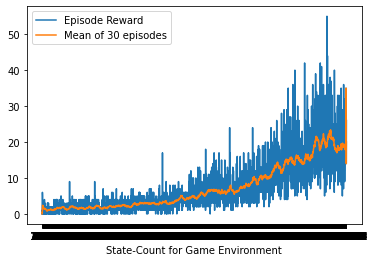

In [15]:
plt.plot(log_reward.count_states, log_reward.episode, label='Episode Reward')
plt.plot(log_reward.count_states, log_reward.mean, label='Mean of 30 episodes')
plt.xlabel('State-Count for Game Environment')
plt.legend()
plt.show()

### Training Progress: Q-Values

The following plot shows the mean Q-values from the replay-memory prior to each run of the optimizer for the Neural Network. Note how the mean Q-values increase rapidly in the beginning and then they increase fairly steadily for 40 million states, after which they still trend upwards but somewhat more irregularly.

The fast improvement in the beginning is probably due to (1) the use of a smaller replay-memory early in training so the Neural Network is optimized more often and the new information is used faster, (2) the backwards-sweeping of the replay-memory so the rewards are used to update the Q-values for many of the states, instead of just updating the Q-values for a single state, and (3) the replay-memory is balanced so at least half of each mini-batch contains states whose Q-values have high estimation-errors for the Neural Network.

The [original paper from DeepMind](https://arxiv.org/abs/1312.5602) showed much slower progress in the first phase of training, see Figure 2 in that paper but note that the Q-values are not directly comparable, possibly because they used a higher discount factor of 0.99 while we only used 0.97 here.

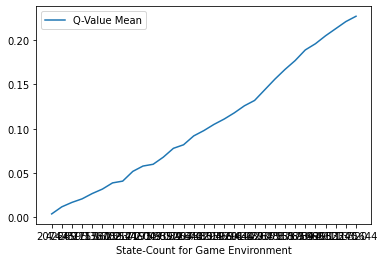

In [16]:
plt.plot(log_q_values.count_states, log_q_values.mean, label='Q-Value Mean')
plt.xlabel('State-Count for Game Environment')
plt.legend()
plt.show()

## Testing

When the agent and Neural Network is being trained, the so-called epsilon-probability is typically decreased from 1.0 to 0.1 over a large number of steps, after which the probability is held fixed at 0.1. This means the probability is 0.1 or 10% that the agent will select a random action in each step, otherwise it will select the action that has the highest Q-value. This is known as the epsilon-greedy policy. The choice of 0.1 for the epsilon-probability is a compromise between taking the actions that are already known to be good, versus exploring new actions that might lead to even higher rewards or might lead to death of the agent.

During testing it is common to lower the epsilon-probability even further. We have set it to 0.01 as shown here:

In [17]:
agent.epsilon_greedy.epsilon_testing

0.01

We will now instruct the agent that it should no longer perform training by setting this boolean:

In [18]:
agent.training = False

We also reset the previous episode rewards.

In [19]:
agent.reset_episode_rewards()

We can render the game-environment to screen so we can see the agent playing the game, by setting this boolean:

In [20]:
agent.render = True

We can now run a single episode by calling the `run()` function again. This should open a new window that shows the game being played by the agent. At the time of this writing, it was not possible to resize this tiny window, and the developers at OpenAI did not seem to care about this feature which should obviously be there.

In [21]:
agent.run(num_episodes=1)

2390:1176749	Q-min: 1.247	Q-max: 1.411	Lives: 5	Reward: 1.0	Episode Mean: 0.0
2390:1176802	Q-min: 1.227	Q-max: 1.425	Lives: 5	Reward: 2.0	Episode Mean: 0.0
2390:1176845	Q-min: 0.109	Q-max: 0.144	Lives: 4	Reward: 2.0	Episode Mean: 0.0
2390:1176899	Q-min: 1.184	Q-max: 1.423	Lives: 4	Reward: 3.0	Episode Mean: 0.0
2390:1176954	Q-min: 1.336	Q-max: 1.472	Lives: 4	Reward: 4.0	Episode Mean: 0.0
2390:1177004	Q-min: 1.303	Q-max: 1.382	Lives: 4	Reward: 5.0	Episode Mean: 0.0
2390:1177050	Q-min: 1.247	Q-max: 1.539	Lives: 4	Reward: 6.0	Episode Mean: 0.0
2390:1177070	Q-min: 0.140	Q-max: 0.149	Lives: 3	Reward: 6.0	Episode Mean: 0.0
2390:1177123	Q-min: 1.260	Q-max: 1.348	Lives: 3	Reward: 7.0	Episode Mean: 0.0
2390:1177171	Q-min: 1.212	Q-max: 1.473	Lives: 3	Reward: 8.0	Episode Mean: 0.0
2390:1177227	Q-min: 1.333	Q-max: 1.445	Lives: 3	Reward: 9.0	Episode Mean: 0.0
2390:1177273	Q-min: 1.285	Q-max: 1.542	Lives: 3	Reward: 10.0	Episode Mean: 0.0
2390:1177304	Q-min: 1.227	Q-max: 1.538	Lives: 3	Reward: 11.0	Ep

### Mean Reward

The game-play is slightly random, both with regard to selecting actions using the epsilon-greedy policy, but also because the OpenAI Gym environment will repeat any action between 2-4 times, with the number chosen at random. So the reward of one episode is not an accurate estimate of the reward that can be expected in general from this agent.

We need to run 30 or even 50 episodes to get a more accurate estimate of the reward that can be expected.

We will first reset the previous episode rewards.

In [22]:
agent.reset_episode_rewards()

We disable the screen-rendering so the game-environment runs much faster.

In [23]:
agent.render = False

We can now run 30 episodes. This records the rewards for each episode. It might have been a good idea to disable the output so it does not print all these lines - you can do this as an exercise.

In [24]:
agent.run(num_episodes=30)

2392:1177839	Q-min: 1.184	Q-max: 1.365	Lives: 5	Reward: 1.0	Episode Mean: 0.0
2392:1177890	Q-min: 1.239	Q-max: 1.387	Lives: 5	Reward: 2.0	Episode Mean: 0.0
2392:1177953	Q-min: 1.205	Q-max: 1.420	Lives: 5	Reward: 3.0	Episode Mean: 0.0
2392:1177999	Q-min: 1.243	Q-max: 1.541	Lives: 5	Reward: 4.0	Episode Mean: 0.0
2392:1178032	Q-min: 1.236	Q-max: 1.516	Lives: 5	Reward: 5.0	Episode Mean: 0.0
2392:1178055	Q-min: 0.050	Q-max: 0.106	Lives: 4	Reward: 5.0	Episode Mean: 0.0
2392:1178106	Q-min: 1.229	Q-max: 1.348	Lives: 4	Reward: 6.0	Episode Mean: 0.0
2392:1178147	Q-min: 0.103	Q-max: 0.128	Lives: 3	Reward: 6.0	Episode Mean: 0.0
2392:1178205	Q-min: 1.239	Q-max: 1.342	Lives: 3	Reward: 7.0	Episode Mean: 0.0
2392:1178269	Q-min: 1.254	Q-max: 1.491	Lives: 3	Reward: 8.0	Episode Mean: 0.0
2392:1178308	Q-min: 0.082	Q-max: 0.123	Lives: 2	Reward: 8.0	Episode Mean: 0.0
2392:1178355	Q-min: 1.247	Q-max: 1.398	Lives: 2	Reward: 9.0	Episode Mean: 0.0
2392:1178382	Q-min: 0.131	Q-max: 0.157	Lives: 1	Reward: 9.0	Epis

2397:1182556	Q-min: 1.242	Q-max: 1.360	Lives: 3	Reward: 5.0	Episode Mean: 16.0
2397:1182598	Q-min: 0.101	Q-max: 0.133	Lives: 2	Reward: 5.0	Episode Mean: 16.0
2397:1182656	Q-min: 1.242	Q-max: 1.447	Lives: 2	Reward: 6.0	Episode Mean: 16.0
2397:1182711	Q-min: 1.266	Q-max: 1.499	Lives: 2	Reward: 7.0	Episode Mean: 16.0
2397:1182763	Q-min: 1.257	Q-max: 1.469	Lives: 2	Reward: 8.0	Episode Mean: 16.0
2397:1182803	Q-min: 0.084	Q-max: 0.123	Lives: 1	Reward: 8.0	Episode Mean: 16.0
2397:1182838	Q-min: 0.112	Q-max: 0.129	Lives: 0	Reward: 8.0	Episode Mean: 14.7
2398:1182879	Q-min: 1.246	Q-max: 1.351	Lives: 5	Reward: 1.0	Episode Mean: 14.7
2398:1182921	Q-min: 1.223	Q-max: 1.593	Lives: 5	Reward: 2.0	Episode Mean: 14.7
2398:1182950	Q-min: 0.049	Q-max: 0.102	Lives: 4	Reward: 2.0	Episode Mean: 14.7
2398:1183003	Q-min: 1.221	Q-max: 1.315	Lives: 4	Reward: 3.0	Episode Mean: 14.7
2398:1183053	Q-min: 1.278	Q-max: 1.396	Lives: 4	Reward: 4.0	Episode Mean: 14.7
2398:1183106	Q-min: 1.283	Q-max: 1.461	Lives: 4	Rewa

2402:1186944	Q-min: 1.235	Q-max: 1.504	Lives: 4	Reward: 2.0	Episode Mean: 17.5
2402:1186996	Q-min: 1.205	Q-max: 1.336	Lives: 4	Reward: 3.0	Episode Mean: 17.5
2402:1187056	Q-min: 1.194	Q-max: 1.407	Lives: 4	Reward: 4.0	Episode Mean: 17.5
2402:1187102	Q-min: 1.261	Q-max: 1.519	Lives: 4	Reward: 5.0	Episode Mean: 17.5
2402:1187123	Q-min: 0.070	Q-max: 0.106	Lives: 3	Reward: 5.0	Episode Mean: 17.5
2402:1187167	Q-min: 1.223	Q-max: 1.614	Lives: 3	Reward: 6.0	Episode Mean: 17.5
2402:1187224	Q-min: 1.242	Q-max: 1.474	Lives: 3	Reward: 7.0	Episode Mean: 17.5
2402:1187289	Q-min: 1.250	Q-max: 1.433	Lives: 3	Reward: 8.0	Episode Mean: 17.5
2402:1187332	Q-min: 0.094	Q-max: 0.128	Lives: 2	Reward: 8.0	Episode Mean: 17.5
2402:1187375	Q-min: 1.150	Q-max: 1.484	Lives: 2	Reward: 12.0	Episode Mean: 17.5
2402:1187434	Q-min: 1.273	Q-max: 1.372	Lives: 2	Reward: 13.0	Episode Mean: 17.5
2402:1187499	Q-min: 1.260	Q-max: 1.461	Lives: 2	Reward: 14.0	Episode Mean: 17.5
2402:1187547	Q-min: 1.192	Q-max: 1.566	Lives: 2	R

2406:1191546	Q-min: 1.255	Q-max: 1.417	Lives: 5	Reward: 1.0	Episode Mean: 20.1
2406:1191594	Q-min: 1.221	Q-max: 1.351	Lives: 5	Reward: 2.0	Episode Mean: 20.1
2406:1191643	Q-min: 1.213	Q-max: 1.629	Lives: 5	Reward: 3.0	Episode Mean: 20.1
2406:1191668	Q-min: 0.109	Q-max: 0.125	Lives: 4	Reward: 3.0	Episode Mean: 20.1
2406:1191720	Q-min: 1.245	Q-max: 1.328	Lives: 4	Reward: 4.0	Episode Mean: 20.1
2406:1191783	Q-min: 1.271	Q-max: 1.310	Lives: 4	Reward: 5.0	Episode Mean: 20.1
2406:1191846	Q-min: 1.247	Q-max: 1.351	Lives: 4	Reward: 6.0	Episode Mean: 20.1
2406:1191892	Q-min: 1.209	Q-max: 1.500	Lives: 4	Reward: 7.0	Episode Mean: 20.1
2406:1191911	Q-min: 0.034	Q-max: 0.094	Lives: 3	Reward: 7.0	Episode Mean: 20.1
2406:1191970	Q-min: 1.208	Q-max: 1.389	Lives: 3	Reward: 8.0	Episode Mean: 20.1
2406:1192036	Q-min: 1.232	Q-max: 1.392	Lives: 3	Reward: 9.0	Episode Mean: 20.1
2406:1192088	Q-min: 1.297	Q-max: 1.460	Lives: 3	Reward: 10.0	Episode Mean: 20.1
2406:1192122	Q-min: 1.253	Q-max: 1.557	Lives: 3	Rew

2410:1196191	Q-min: 1.271	Q-max: 1.507	Lives: 1	Reward: 15.0	Episode Mean: 20.0
2410:1196245	Q-min: 1.307	Q-max: 1.438	Lives: 1	Reward: 16.0	Episode Mean: 20.0
2410:1196273	Q-min: 0.032	Q-max: 0.089	Lives: 0	Reward: 16.0	Episode Mean: 19.8
2411:1196317	Q-min: 1.245	Q-max: 1.454	Lives: 5	Reward: 1.0	Episode Mean: 19.8
2411:1196369	Q-min: 1.232	Q-max: 1.374	Lives: 5	Reward: 2.0	Episode Mean: 19.8
2411:1196408	Q-min: 0.145	Q-max: 0.168	Lives: 4	Reward: 2.0	Episode Mean: 19.8
2411:1196464	Q-min: 1.254	Q-max: 1.314	Lives: 4	Reward: 3.0	Episode Mean: 19.8
2411:1196514	Q-min: 1.190	Q-max: 1.468	Lives: 4	Reward: 4.0	Episode Mean: 19.8
2411:1196556	Q-min: 1.284	Q-max: 1.550	Lives: 4	Reward: 5.0	Episode Mean: 19.8
2411:1196585	Q-min: 0.108	Q-max: 0.136	Lives: 3	Reward: 5.0	Episode Mean: 19.8
2411:1196639	Q-min: 1.205	Q-max: 1.403	Lives: 3	Reward: 6.0	Episode Mean: 19.8
2411:1196700	Q-min: 1.224	Q-max: 1.469	Lives: 3	Reward: 7.0	Episode Mean: 19.8
2411:1196764	Q-min: 1.271	Q-max: 1.385	Lives: 3	R

2415:1200760	Q-min: 1.242	Q-max: 1.342	Lives: 4	Reward: 2.0	Episode Mean: 20.5
2415:1200812	Q-min: 1.206	Q-max: 1.542	Lives: 4	Reward: 3.0	Episode Mean: 20.5
2415:1200839	Q-min: 0.098	Q-max: 0.135	Lives: 3	Reward: 3.0	Episode Mean: 20.5
2415:1200892	Q-min: 1.232	Q-max: 1.352	Lives: 3	Reward: 4.0	Episode Mean: 20.5
2415:1200958	Q-min: 1.225	Q-max: 1.471	Lives: 3	Reward: 5.0	Episode Mean: 20.5
2415:1201015	Q-min: 1.309	Q-max: 1.508	Lives: 3	Reward: 6.0	Episode Mean: 20.5
2415:1201042	Q-min: 0.072	Q-max: 0.120	Lives: 2	Reward: 6.0	Episode Mean: 20.5
2415:1201086	Q-min: 1.277	Q-max: 1.517	Lives: 2	Reward: 7.0	Episode Mean: 20.5
2415:1201141	Q-min: 1.229	Q-max: 1.447	Lives: 2	Reward: 8.0	Episode Mean: 20.5
2415:1201194	Q-min: 1.259	Q-max: 1.575	Lives: 2	Reward: 12.0	Episode Mean: 20.5
2415:1201235	Q-min: 1.259	Q-max: 1.525	Lives: 2	Reward: 13.0	Episode Mean: 20.5
2415:1201258	Q-min: 0.061	Q-max: 0.113	Lives: 1	Reward: 13.0	Episode Mean: 20.5
2415:1201310	Q-min: 1.261	Q-max: 1.372	Lives: 1	R

2420:1205522	Q-min: 1.275	Q-max: 1.439	Lives: 4	Reward: 3.0	Episode Mean: 20.5
2420:1205575	Q-min: 1.333	Q-max: 1.425	Lives: 4	Reward: 4.0	Episode Mean: 20.5
2420:1205617	Q-min: 0.101	Q-max: 0.136	Lives: 3	Reward: 4.0	Episode Mean: 20.5
2420:1205672	Q-min: 1.256	Q-max: 1.338	Lives: 3	Reward: 5.0	Episode Mean: 20.5
2420:1205732	Q-min: 1.245	Q-max: 1.397	Lives: 3	Reward: 6.0	Episode Mean: 20.5
2420:1205784	Q-min: 1.299	Q-max: 1.454	Lives: 3	Reward: 7.0	Episode Mean: 20.5
2420:1205820	Q-min: 1.227	Q-max: 1.574	Lives: 3	Reward: 8.0	Episode Mean: 20.5
2420:1205852	Q-min: 1.246	Q-max: 1.460	Lives: 3	Reward: 9.0	Episode Mean: 20.5
2420:1205887	Q-min: 1.365	Q-max: 1.435	Lives: 3	Reward: 10.0	Episode Mean: 20.5
2420:1205909	Q-min: 0.131	Q-max: 0.145	Lives: 2	Reward: 10.0	Episode Mean: 20.5
2420:1205954	Q-min: 1.252	Q-max: 1.531	Lives: 2	Reward: 11.0	Episode Mean: 20.5
2420:1205985	Q-min: 0.097	Q-max: 0.133	Lives: 1	Reward: 11.0	Episode Mean: 20.5
2420:1206029	Q-min: 1.203	Q-max: 1.463	Lives: 1	

We can now print some statistics for the episode rewards, which vary greatly from one episode to the next.

In [25]:
rewards = agent.episode_rewards
print("Rewards for {0} episodes:".format(len(rewards)))
print("- Min:   ", np.min(rewards))
print("- Mean:  ", np.mean(rewards))
print("- Max:   ", np.max(rewards))
print("- Stdev: ", np.std(rewards))

Rewards for 30 episodes:
- Min:    8.0
- Mean:   20.866666666666667
- Max:    40.0
- Stdev:  8.155706931686273


We can also plot a histogram with the episode rewards.

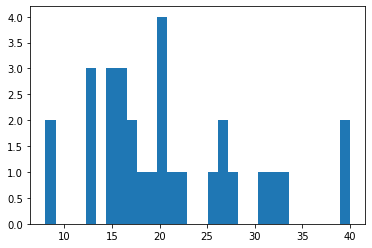

In [26]:
_ = plt.hist(rewards, bins=30)

## Example States

We can plot examples of states from the game-environment and the Q-values that are estimated by the Neural Network.

This helper-function prints the Q-values for a given index in the replay-memory.

In [27]:
def print_q_values(idx):
    """Print Q-values and actions from the replay-memory at the given index."""

    # Get the Q-values and action from the replay-memory.
    q_values = replay_memory.q_values[idx]
    action = replay_memory.actions[idx]

    print("Action:     Q-Value:")
    print("====================")

    # Print all the actions and their Q-values.
    for i, q_value in enumerate(q_values):
        # Used to display which action was taken.
        if i == action:
            action_taken = "(Action Taken)"
        else:
            action_taken = ""

        # Text-name of the action.
        action_name = agent.get_action_name(i)
            
        print("{0:12}{1:.3f} {2}".format(action_name, q_value,
                                        action_taken))

    # Newline.
    print()

This helper-function plots a state from the replay-memory and optionally prints the Q-values.

In [28]:
def plot_state(idx, print_q=True):
    """Plot the state in the replay-memory with the given index."""

    # Get the state from the replay-memory.
    state = replay_memory.states[idx]
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(1, 2)

    # Plot the image from the game-environment.
    ax = axes.flat[0]
    ax.imshow(state[:, :, 0], vmin=0, vmax=255,
              interpolation='lanczos', cmap='gray')

    # Plot the motion-trace.
    ax = axes.flat[1]
    ax.imshow(state[:, :, 1], vmin=0, vmax=255,
              interpolation='lanczos', cmap='gray')

    # This is necessary if we show more than one plot in a single Notebook cell.
    plt.show()
    
    # Print the Q-values.
    if print_q:
        print_q_values(idx=idx)

The replay-memory has room for 200k states but it is only partially full from the above call to `agent.run(num_episodes=1)`. This is how many states are actually used.

In [29]:
num_used = replay_memory.num_used
num_used

1061

Get the Q-values from the replay-memory that are actually used.

In [30]:
q_values = replay_memory.q_values[0:num_used, :]

For each state, calculate the min / max Q-values and their difference. This will be used to lookup interesting states in the following sections.

In [31]:
q_values_min = q_values.min(axis=1)
q_values_max = q_values.max(axis=1)
q_values_dif = q_values_max - q_values_min

### Example States: Highest Reward

This example shows the states surrounding the state with the highest reward.

During the training we limit the rewards to the range [-1, 1] so this basically just gets the first state that has a reward of 1.

In [32]:
idx = np.argmax(replay_memory.rewards)
idx

42

This state is where the ball hits the wall so the agent scores a point. 

We can show the surrounding states leading up to and following this state. Note how the Q-values are very close for the different actions, because at this point it really does not matter what the agent does as the reward is already guaranteed. But note how the Q-values decrease significantly after the ball has hit the wall and a point has been scored.

Also note that the agent uses the Epsilon-greedy policy for taking actions, so there is a small probability that a random action is taken instead of the action with the highest Q-value.

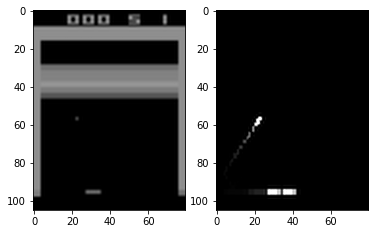

Action:     Q-Value:
NOOP        1.188 
FIRE        1.169 
RIGHT       1.148 
LEFT        1.278 (Action Taken)



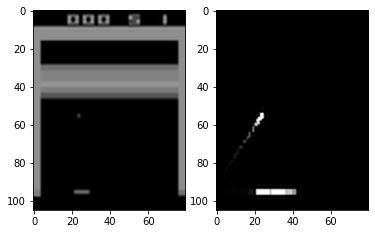

Action:     Q-Value:
NOOP        1.220 
FIRE        1.206 
RIGHT       1.163 
LEFT        1.310 (Action Taken)



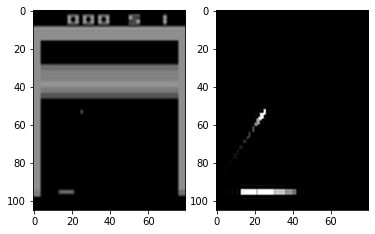

Action:     Q-Value:
NOOP        1.360 (Action Taken)
FIRE        1.271 
RIGHT       1.217 
LEFT        1.274 



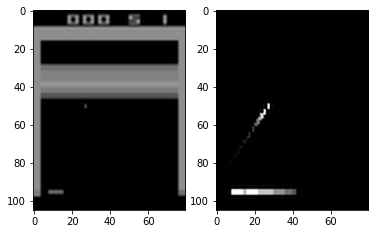

Action:     Q-Value:
NOOP        1.301 
FIRE        1.335 (Action Taken)
RIGHT       1.243 
LEFT        1.305 



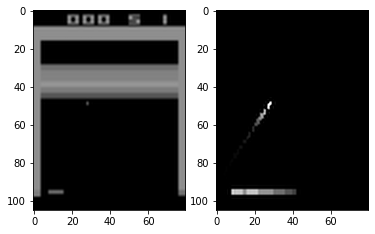

Action:     Q-Value:
NOOP        1.307 
FIRE        1.337 
RIGHT       1.255 
LEFT        1.435 (Action Taken)



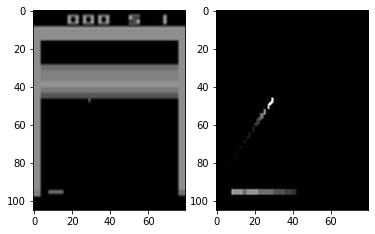

Action:     Q-Value:
NOOP        1.362 
FIRE        1.359 
RIGHT       1.260 
LEFT        1.496 (Action Taken)



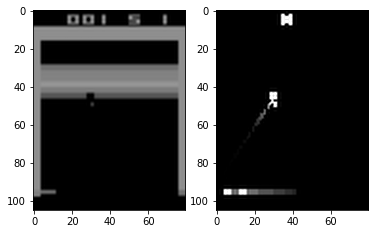

Action:     Q-Value:
NOOP        0.391 
FIRE        0.377 
RIGHT       0.366 (Action Taken)
LEFT        0.430 



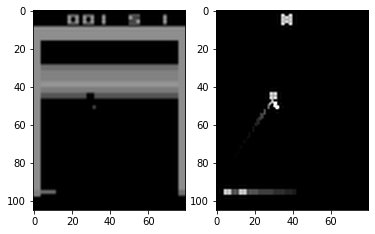

Action:     Q-Value:
NOOP        0.394 
FIRE        0.386 
RIGHT       0.369 
LEFT        0.436 (Action Taken)



In [33]:
for i in range(-5, 3):
    plot_state(idx=idx+i)

### Example: Highest Q-Value

This example shows the states surrounding the one with the highest Q-values. This means that the agent has high expectation that several points will be scored in the following steps. Note that the Q-values decrease significantly after the points have been scored.

In [34]:
idx = np.argmax(q_values_max)
idx

517

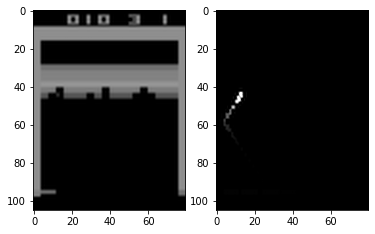

Action:     Q-Value:
NOOP        1.289 
FIRE        1.206 
RIGHT       1.333 
LEFT        1.653 (Action Taken)



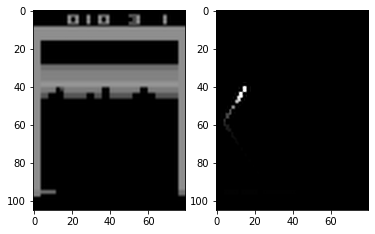

Action:     Q-Value:
NOOP        1.073 
FIRE        1.088 
RIGHT       1.106 
LEFT        1.239 (Action Taken)



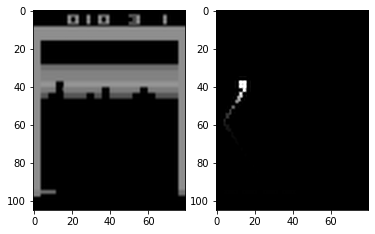

Action:     Q-Value:
NOOP        0.563 
FIRE        0.589 
RIGHT       0.629 (Action Taken)
LEFT        0.553 



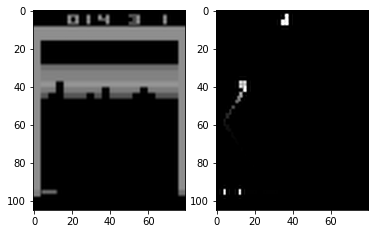

Action:     Q-Value:
NOOP        0.506 
FIRE        0.514 
RIGHT       0.564 (Action Taken)
LEFT        0.548 



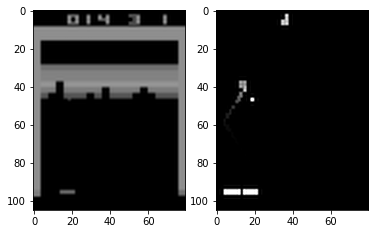

Action:     Q-Value:
NOOP        0.503 
FIRE        0.513 
RIGHT       0.559 (Action Taken)
LEFT        0.520 



In [35]:
for i in range(0, 5):
    plot_state(idx=idx+i)

### Example: Loss of Life

This example shows the states leading up to a loss of life for the agent.

In [36]:
idx = np.argmax(replay_memory.end_life)
idx

115

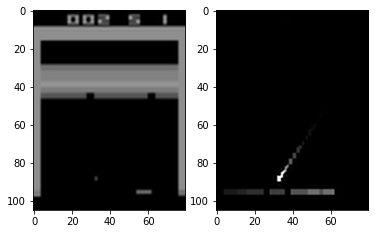

Action:     Q-Value:
NOOP        0.627 (Action Taken)
FIRE        0.617 
RIGHT       0.605 
LEFT        0.585 



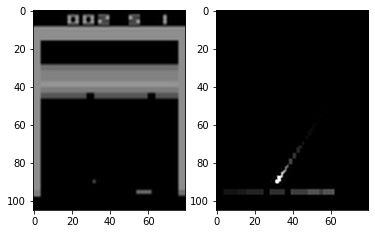

Action:     Q-Value:
NOOP        0.585 
FIRE        0.589 (Action Taken)
RIGHT       0.566 
LEFT        0.564 



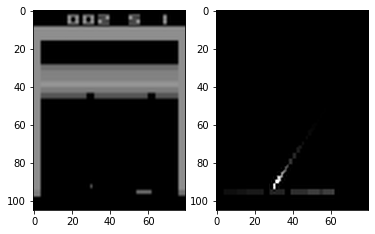

Action:     Q-Value:
NOOP        0.378 
FIRE        0.380 (Action Taken)
RIGHT       0.375 
LEFT        0.360 



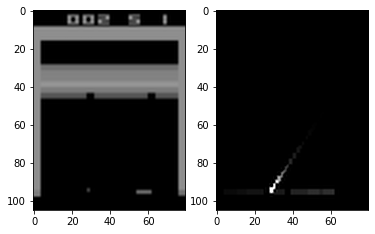

Action:     Q-Value:
NOOP        0.225 
FIRE        0.232 
RIGHT       0.232 
LEFT        0.236 (Action Taken)



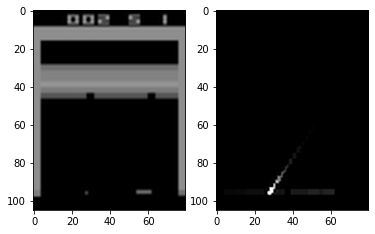

Action:     Q-Value:
NOOP        0.197 
FIRE        0.203 
RIGHT       0.217 (Action Taken)
LEFT        0.208 



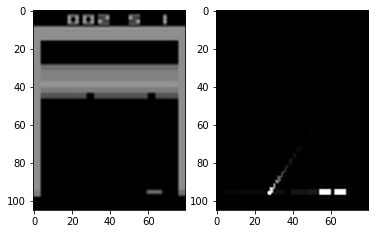

Action:     Q-Value:
NOOP        0.184 (Action Taken)
FIRE        0.171 
RIGHT       0.188 
LEFT        0.183 



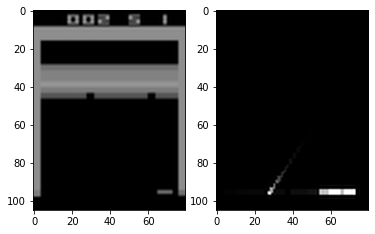

Action:     Q-Value:
NOOP        0.187 
FIRE        0.177 
RIGHT       0.194 (Action Taken)
LEFT        0.191 



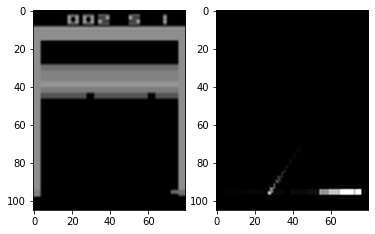

Action:     Q-Value:
NOOP        0.149 (Action Taken)
FIRE        0.113 
RIGHT       0.141 
LEFT        0.126 



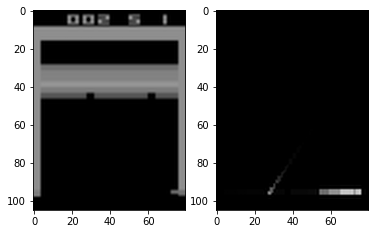

Action:     Q-Value:
NOOP        0.140 (Action Taken)
FIRE        0.108 
RIGHT       0.132 
LEFT        0.111 



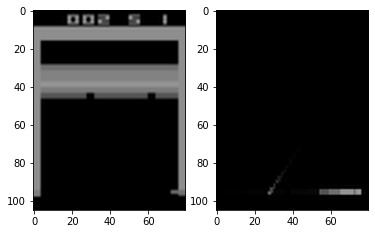

Action:     Q-Value:
NOOP        0.137 (Action Taken)
FIRE        0.109 
RIGHT       0.130 
LEFT        0.105 



In [37]:
for i in range(-10, 0):
    plot_state(idx=idx+i)

### Example: Greatest Difference in Q-Values

This example shows the state where there is the greatest difference in Q-values, which means that the agent believes one action will be much more beneficial than another. But because the agent uses the Epsilon-greedy policy, it sometimes selects a random action instead.

In [38]:
idx = np.argmax(q_values_dif)
idx

699

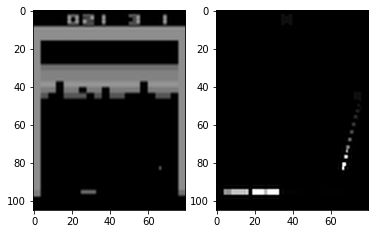

Action:     Q-Value:
NOOP        0.428 
FIRE        0.428 
RIGHT       0.906 (Action Taken)
LEFT        0.358 



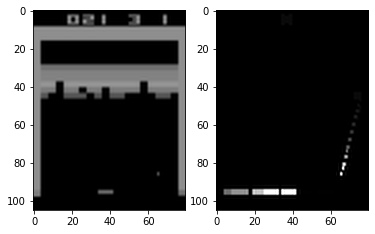

Action:     Q-Value:
NOOP        0.391 
FIRE        0.426 
RIGHT       0.849 (Action Taken)
LEFT        0.311 



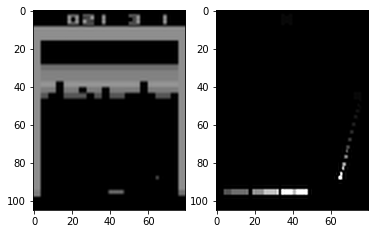

Action:     Q-Value:
NOOP        0.413 
FIRE        0.486 
RIGHT       0.852 (Action Taken)
LEFT        0.306 



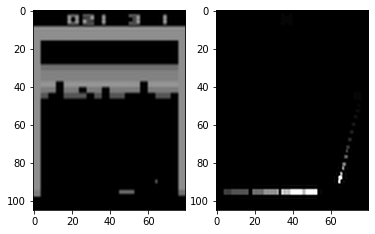

Action:     Q-Value:
NOOP        0.409 
FIRE        0.434 
RIGHT       0.737 (Action Taken)
LEFT        0.332 



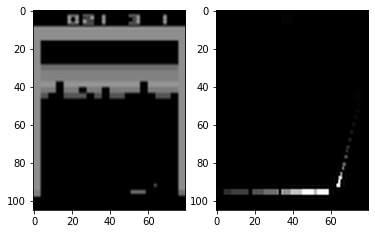

Action:     Q-Value:
NOOP        0.443 
FIRE        0.692 (Action Taken)
RIGHT       0.585 
LEFT        0.308 



In [39]:
for i in range(0, 5):
    plot_state(idx=idx+i)

### Example: Smallest Difference in Q-Values

This example shows the state where there is the smallest difference in Q-values, which means that the agent believes it does not really matter which action it selects, as they all have roughly the same expectations for future rewards.

The Neural Network estimates these Q-values and they are not precise. The differences in Q-values may be so small that they fall within the error-range of the estimates.

In [40]:
idx = np.argmin(q_values_dif)
idx

134

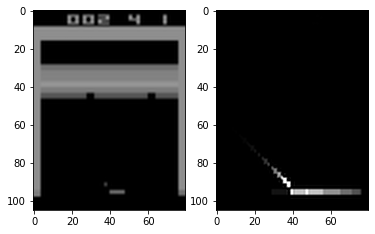

Action:     Q-Value:
NOOP        0.600 (Action Taken)
FIRE        0.595 
RIGHT       0.596 
LEFT        0.599 



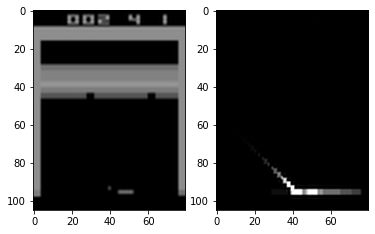

Action:     Q-Value:
NOOP        0.572 
FIRE        0.566 
RIGHT       0.545 
LEFT        0.704 (Action Taken)



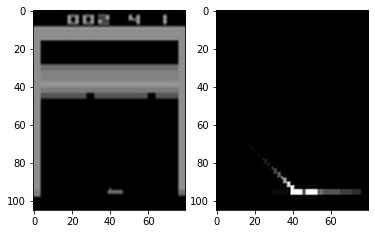

Action:     Q-Value:
NOOP        0.654 
FIRE        0.674 
RIGHT       0.663 (Action Taken)
LEFT        0.615 



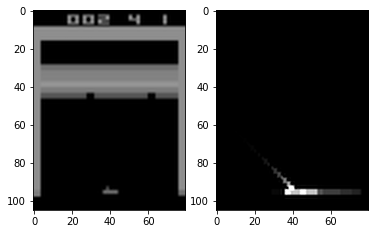

Action:     Q-Value:
NOOP        0.655 (Action Taken)
FIRE        0.646 
RIGHT       0.719 
LEFT        0.648 



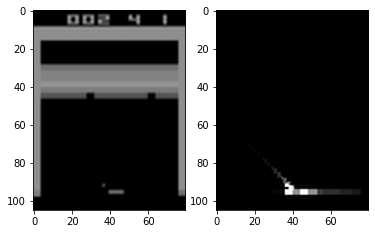

Action:     Q-Value:
NOOP        0.686 (Action Taken)
FIRE        0.660 
RIGHT       0.675 
LEFT        0.675 



In [41]:
for i in range(0, 5):
    plot_state(idx=idx+i)

## Output of Convolutional Layers

The outputs of the convolutional layers can be plotted so we can see how the images from the game-environment are being processed by the Neural Network.

This is the helper-function for plotting the output of the convolutional layer with the given name, when inputting the given state from the replay-memory.

In [42]:
def plot_layer_output(model, layer_name, state_index, inverse_cmap=False):
    """
    Plot the output of a convolutional layer.

    :param model: An instance of the NeuralNetwork-class.
    :param layer_name: Name of the convolutional layer.
    :param state_index: Index into the replay-memory for a state that
                        will be input to the Neural Network.
    :param inverse_cmap: Boolean whether to inverse the color-map.
    """

    # Get the given state-array from the replay-memory.
    state = replay_memory.states[state_index]
    
    # Get the output tensor for the given layer inside the TensorFlow graph.
    # This is not the value-contents but merely a reference to the tensor.
    layer_tensor = model.get_layer_tensor(layer_name=layer_name)
    
    # Get the actual value of the tensor by feeding the state-data
    # to the TensorFlow graph and calculating the value of the tensor.
    values = model.get_tensor_value(tensor=layer_tensor, state=state)

    # Number of image channels output by the convolutional layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))

    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(10, 10))

    print("Dim. of each image:", values.shape)
    
    if inverse_cmap:
        cmap = 'gray_r'
    else:
        cmap = 'gray'

    # Plot the outputs of all the channels in the conv-layer.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i < num_images:
            # Get the image for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap=cmap)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


### Game State

This is the state that is being input to the Neural Network. The image on the left is the last image from the game-environment. The image on the right is the processed motion-trace that shows the trajectories of objects in the game-environment.

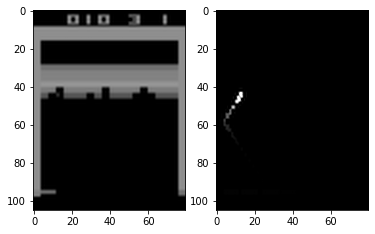

In [43]:
idx = np.argmax(q_values_max)
plot_state(idx=idx, print_q=False)

### Output of Convolutional Layer 1

This shows the images that are output by the 1st convolutional layer, when inputting the above state to the Neural Network. There are 16 output channels of this convolutional layer.

Note that you can invert the colors by setting `inverse_cmap=True` in the parameters to this function.

Dim. of each image: (1, 53, 40, 16)


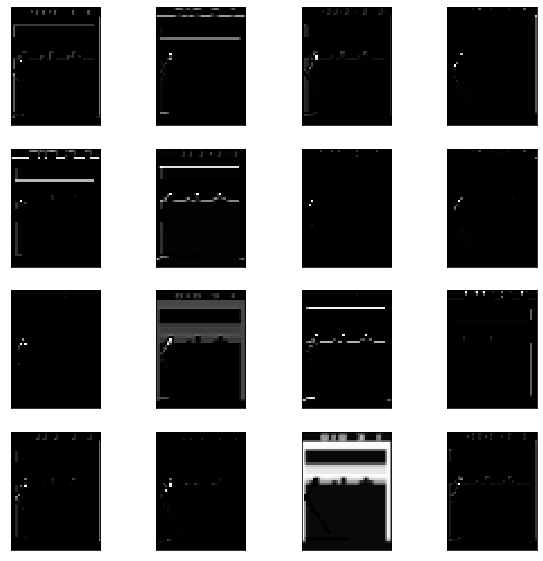

In [44]:
plot_layer_output(model=model, layer_name='layer_conv1', state_index=idx, inverse_cmap=False)

### Output of Convolutional Layer 2

These are the images output by the 2nd convolutional layer, when inputting the above state to the Neural Network. There are 32 output channels of this convolutional layer.

Dim. of each image: (1, 27, 20, 32)


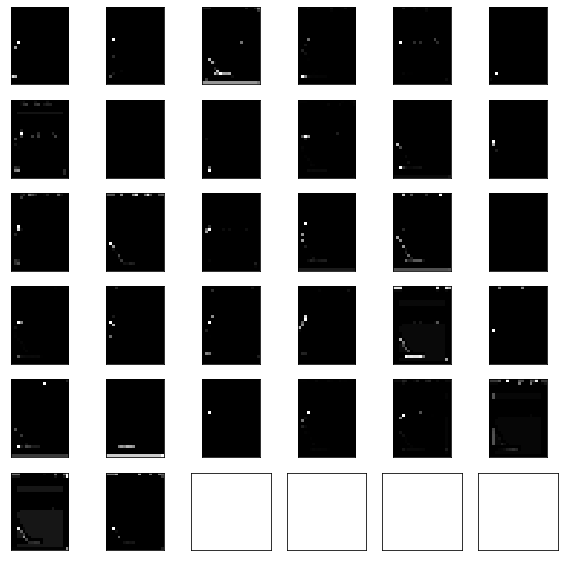

In [45]:
plot_layer_output(model=model, layer_name='layer_conv2', state_index=idx, inverse_cmap=False)

### Output of Convolutional Layer 3

These are the images output by the 3rd convolutional layer, when inputting the above state to the Neural Network. There are 64 output channels of this convolutional layer.

All these images are flattened to a one-dimensional array (or tensor) which is then used as the input to a fully-connected layer in the Neural Network.

During the training-process, the Neural Network has learnt what convolutional filters to apply to the images from the game-environment so as to produce these images, because they have proven to be useful when estimating Q-values.

Can you see what it is that the Neural Network has learned to detect in these images?

Dim. of each image: (1, 27, 20, 64)


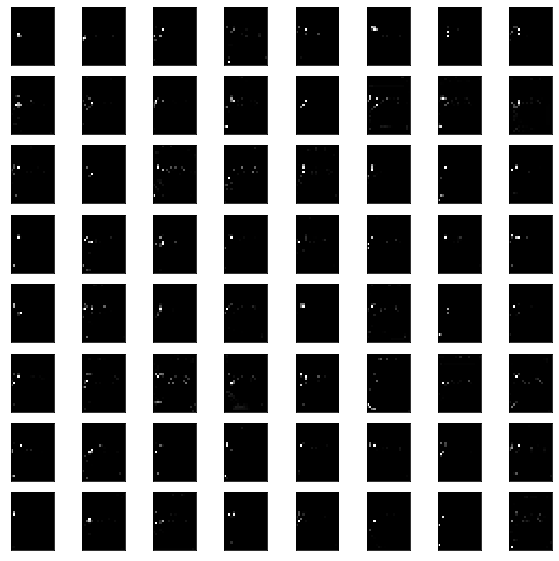

In [46]:
plot_layer_output(model=model, layer_name='layer_conv3', state_index=idx, inverse_cmap=False)

## Weights for Convolutional Layers

We can also plot the weights of the convolutional layers in the Neural Network. These are the weights that are being optimized so as to improve the ability of the Neural Network to estimate Q-values. Tutorial #02 explains in greater detail what convolutional weights are.
There are also weights for the fully-connected layers but they are not shown here.

This is the helper-function for plotting the weights of a convoluational layer.

In [47]:
def plot_conv_weights(model, layer_name, input_channel=0):
    """
    Plot the weights for a convolutional layer.
    
    :param model: An instance of the NeuralNetwork-class.
    :param layer_name: Name of the convolutional layer.
    :param input_channel: Plot the weights for this input-channel.
    """

    # Get the variable for the weights of the given layer.
    # This is a reference to the variable inside TensorFlow,
    # not its actual value.
    weights_variable = model.get_weights_variable(layer_name=layer_name)
    
    # Retrieve the values of the weight-variable from TensorFlow.
    # The format of this 4-dim tensor is determined by the
    # TensorFlow API. See Tutorial #02 for more details.
    w = model.get_variable_value(variable=weights_variable)

    # Get the weights for the given input-channel.
    w_channel = w[:, :, input_channel, :]
    
    # Number of output-channels for the conv. layer.
    num_output_channels = w_channel.shape[2]

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w_channel)
    w_max = np.max(w_channel)

    # This is used to center the colour intensity at zero.
    abs_max = max(abs(w_min), abs(w_max))

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w_min, w_max))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w_channel.mean(),
                                                 w_channel.std()))

    # Number of grids to plot.
    # Rounded-up, square-root of the number of output-channels.
    num_grids = math.ceil(math.sqrt(num_output_channels))

    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i < num_output_channels:
            # Get the weights for the i'th filter of this input-channel.
            img = w_channel[:, :, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Weights for Convolutional Layer 1

These are the weights of the first convolutional layer of the Neural Network, with respect to the first input channel of the state. That is, these are the weights that are used on the image from the game-environment. Some basic statistics are also shown.

Note how the weights are more negative (blue) than positive (red). It is unclear why this happens as these weights are found through optimization. It is apparently beneficial for the following layers to have this processing with more negative weights in the first convolutional layer.

Min:  -0.24494, Max:   0.13658
Mean: -0.01729, Stdev: 0.06023


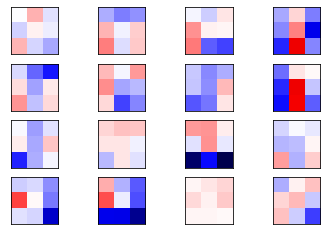

In [48]:
plot_conv_weights(model=model, layer_name='layer_conv1', input_channel=0)

We can also plot the convolutional weights for the second input channel, that is, the motion-trace of the game-environment. Once again we see that the negative weights (blue) have a much greater magnitude than the positive weights (red).

Min:  -0.56904, Max:   0.06957
Mean: -0.05132, Stdev: 0.12694


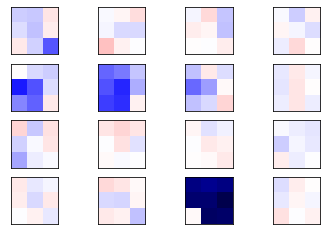

In [49]:
plot_conv_weights(model=model, layer_name='layer_conv1', input_channel=1)

### Weights for Convolutional Layer 2

These are the weights of the 2nd convolutional layer in the Neural Network. There are 16 input channels and 32 output channels of this layer. You can change the number for the input-channel to see the associated weights.

Note how the weights are more balanced between positive (red) and negative (blue) compared to the weights for the 1st convolutional layer above.

Min:  -0.24590, Max:   0.14826
Mean: -0.00605, Stdev: 0.06365


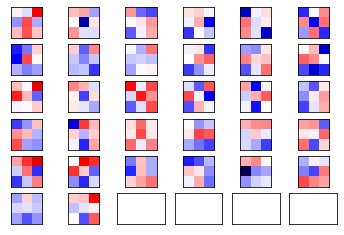

In [50]:
plot_conv_weights(model=model, layer_name='layer_conv2', input_channel=0)

### Weights for Convolutional Layer 3

These are the weights of the 3rd convolutional layer in the Neural Network. There are 32 input channels and 64 output channels of this layer. You can change the number for the input-channel to see the associated weights.

Note again how the weights are more balanced between positive (red) and negative (blue) compared to the weights for the 1st convolutional layer above.

Min:  -0.25325, Max:   0.17733
Mean: -0.03257, Stdev: 0.07194


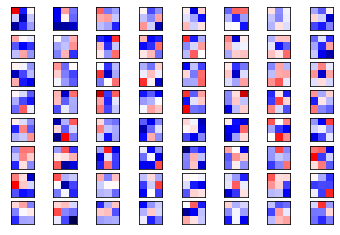

In [51]:
plot_conv_weights(model=model, layer_name='layer_conv3', input_channel=0)

## Discussion

We trained an agent to play old Atari games quite well using Reinforcement Learning. Recent improvements to the training algorithm have improved the performance significantly. But is this true human-like intelligence? The answer is clearly NO!

Reinforcement Learning in its current form is a crude numerical algorithm for connecting visual images, actions, rewards and penalties when there is a time-lag between the signals. The learning is based on trial-and-error and cannot do logical reasoning like a human. The agent has no sense of "self" while a human has an understanding of what part of the game-environment it is controlling, so a human can reason logically like this: "(A) I control the paddle, and (B) I must avoid dying which happens when the ball flies past the paddle, so (C) I must move the paddle to hit the ball, and (D) this automatically scores points when the ball smashes bricks in the wall". A human would first learn these basic logical rules of the game - and then try and refine the eye-hand coordination to play the game better. Reinforcement Learning has no real comprehension of what is going on in the game and merely works on improving the eye-hand coordination until it gets lucky and does the right thing to score more points.

Furthermore, the training of the Reinforcement Learning algorithm required almost 150 hours of computation which played the game at high speeds. If the game was played at normal real-time speeds then it would have taken more than 1700 hours to train the agent, which is more than 70 days and nights.

Logical reasoning would allow for much faster learning than Reinforcement Learning, and it would be able to solve much more complicated problems than simple eye-hand coordination. I am skeptical if someone will be able to create true human-like intelligence from Reinforcement Learning algorithms.

Does that mean Reinforcement Learning is completely worthless? No, it has real-world applications that currently cannot be solved by other methods.

Another point of criticism is the use of Neural Networks. The majority of the research in Reinforcement Learning is actually spent on trying to stabilize the training of the Neural Network using various tricks. This is a waste of research time and strongly indicates that Neural Networks may not be a very good Machine Learning model compared to the human brain.

## Exercises & Research Ideas

Below are suggestions for exercises and experiments that may help improve your skills with TensorFlow and Reinforcement Learning. Some of these ideas can easily be extended into full research problems that would help the community if you can solve them.

You should keep a log of your experiments, describing for each experiment the settings you tried and the results. You should also save the source-code and checkpoints / log-files.

It takes so much time to run these experiments, so please share your results with the rest of the community. Even if an experiment failed to produce anything useful, it will be helpful to others so they know not to redo the same experiment.

[Thread on GitHub for discussing these experiments](https://github.com/Hvass-Labs/TensorFlow-Tutorials/issues/32)

You may want to backup this Notebook and the other files before making any changes.

You may find it helpful to add more command-line parameters to `reinforcement_learning.py` so you don't have to edit the source-code for testing other parameters.

* Change the epsilon-probability during testing to e.g. 0.001 or 0.05. Which gives the best results? Could you use this value during training? Why/not?
* Try and change the game-environment to Space Invaders and re-run this Notebook. The hyper-parameters such as the learning-rate were tuned for Breakout. Can you make some kind of adaptive learning-rate that would work better for both Breakout and Space Invaders? What about the other hyper-parameters? What about other games?
* Try different architectures for the Neural Network. You will need to restart the training because the checkpoints cannot be reused for other architectures. You will need to train the agent for several days with each new architecture so as to properly assess its performance.
* The replay-memory throws away all data after optimization of the Neural Network. Can you make it reuse the data somehow? The ReplayMemory-class has the function `estimate_all_q_values()` which may be helpful.
* The reward is limited to -1 and 1 in the function `ReplayMemory.add()` so as to stabilize the training. This means the agent cannot distinguish between small and large rewards. Can you use batch normalization to fix this problem, so you can use the actual reward values?
* Can you improve the training by adding L2-regularization or dropout?
* Try using other optimizers for the Neural Network. Does it help with the training speed or stability?
* Let the agent take up to 30 random actions at the beginning of each new episode. This is used in some research papers to further randomize the game-environment, so the agent cannot memorize the first sequence of actions.
* Try and save the game at regular intervals. If the agent dies, then you can reload the last saved game. Would this help training the agent faster and better, because it does not need to play the game from the beginning?
* There are some invalid actions available to the agent in OpenAI Gym. Does it improve the training if you only allow the valid actions from the game-environment?
* Does the MotionTracer work for other games? Can you improve on the MotionTracer?
* Try and use the last 4 image-frames from the game instead of the MotionTracer.
* Try larger and smaller sizes for the replay memory.
* Try larger and smaller discount rates for updating the Q-values.
* If you look closely in the states and actions that are display above, you will note that the agent has sometimes taken actions that do not correspond to the movement of the paddle. For example, the action might be LEFT but the paddle has either not moved at all, or it has moved right instead. Is this a bug in the source-code for this tutorial, or is it a bug in OpenAI Gym, or is it a bug in the underlying Atari Learning Environment? Does it matter?

## License (MIT)

Copyright (c) 2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.